In [47]:
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import datetime

# Nós vamos olhar para os preçoes de ações ao longo do último ano, começando em 1o de Janeiro de 2016
start = datetime.datetime(2016,6,1)
end = datetime.date.today()

# Vamos pegar dados da Petrobras; O seu símbolo é PETR3 e a bolsa é BVMF
# O primemiro argumento é o que queremos, o segundo é a fonte ("google" para Google Finance), a terceira é a data inicial, a quarta é a data final
petr3 = wb.DataReader("BVMF:PETR3", "google", start, end)
 
type(petr3)

pandas.core.frame.DataFrame

In [48]:
petr3.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-06-01,10.15,10.52,9.95,10.41,10757600
2016-06-02,10.38,10.75,10.20,10.70,8738800
2016-06-03,10.79,10.99,10.67,10.81,8093200
2016-06-06,10.98,11.04,10.74,10.80,8058600
2016-06-07,10.75,11.28,10.68,11.13,13024500


Populating the interactive namespace from numpy and matplotlib


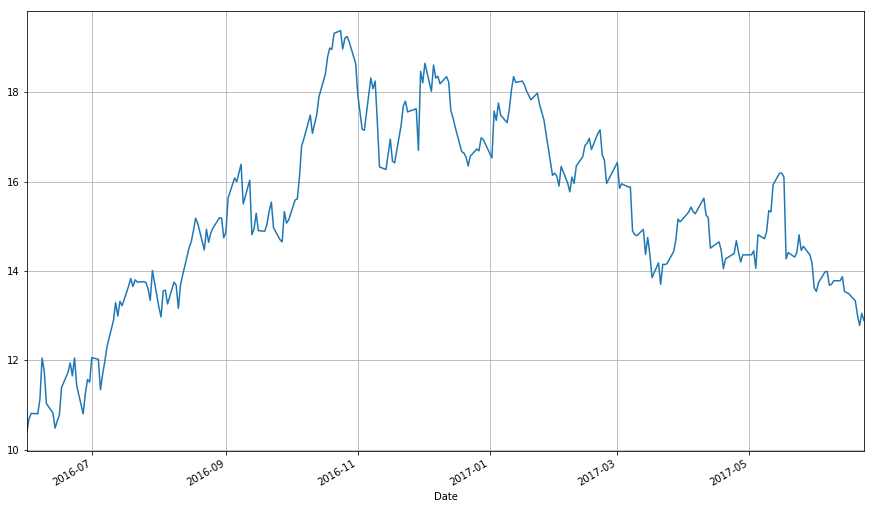

In [49]:
# Esta linha é necessária para o gráfico aparecer no Jupyter notebook
%matplotlib inline
# Controle o valor padrão das figuras no Jupyter notebook
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Troca o tamanho dos gráficos

petr3["Close"].plot(grid = True) # Cria um gráfico com o preço de fechamento diário da PETR3

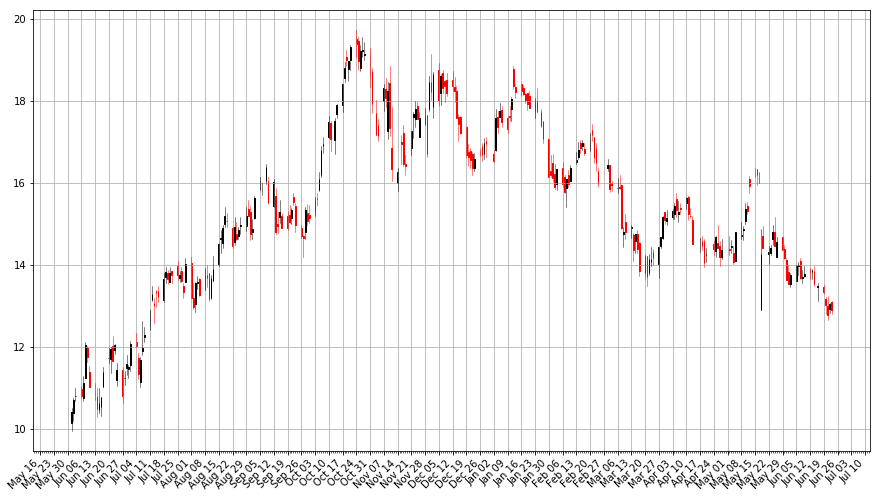

In [50]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 
pandas_candlestick_ohlc(petr3)

In [53]:
itub3 = wb.DataReader("BVMF:ITUB3", "google", start, end)
abev3 = wb.DataReader("BVMF:ABEV3", "google", start, end)
 
# A seguir eu crio um DataFrame consistindo dos preços de fechamento ajustados dessas ações.
stocks = pd.DataFrame({"PETR3": petr3["Close"],
                      "ITUB3": itub3["Close"],
                      "ABEV3": abev3["Close"]})
 
stocks.head()

,ABEV3,ITUB3,PETR3
Date,,,
2016-06-01,19.34,23.59,10.41
2016-06-02,19.28,24.07,10.70
2016-06-03,19.50,24.13,10.81
2016-06-06,19.42,23.93,10.80
2016-06-07,19.09,24.11,11.13


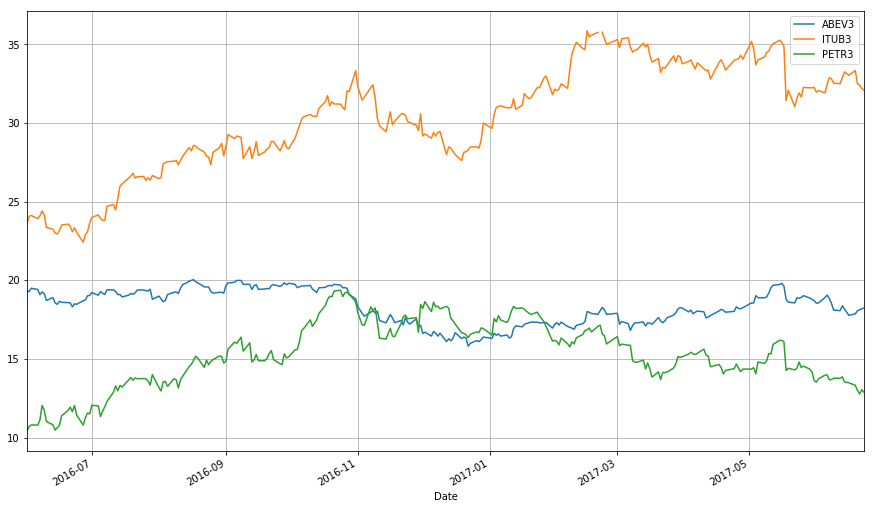

In [54]:
stocks.plot(grid = True)

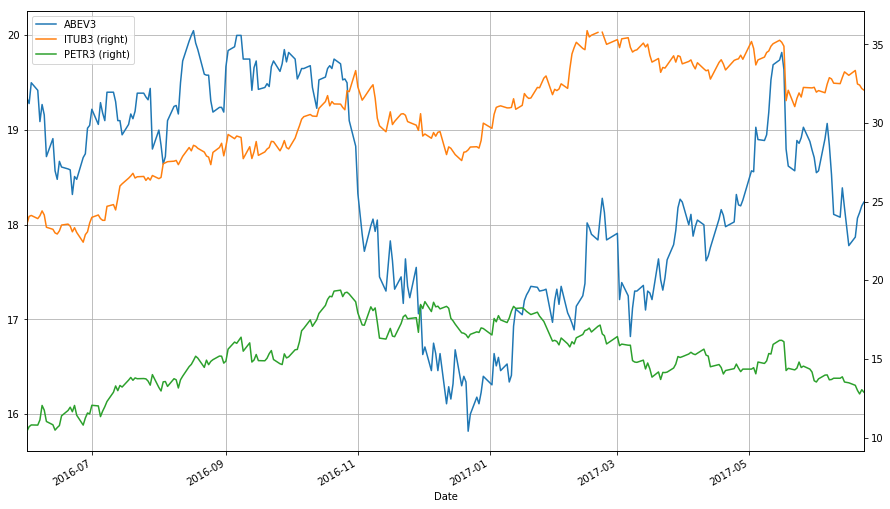

In [55]:
stocks.plot(secondary_y = ["PETR3", "ITUB3"], grid = True)

In [56]:
# apply(arg) irá aplicar a função passada por argumento para cada coluna no dataframe, e retorna o DataFrame com o resultado final.
stock_return = stocks.apply(lambda x: x / x[0])
stock_return.head()

,ABEV3,ITUB3,PETR3
Date,,,
2016-06-01,1.000000,1.000000,1.000000
2016-06-02,0.996898,1.020348,1.027858
2016-06-03,1.008273,1.022891,1.038425
2016-06-06,1.004137,1.014413,1.037464
2016-06-07,0.987073,1.022043,1.069164


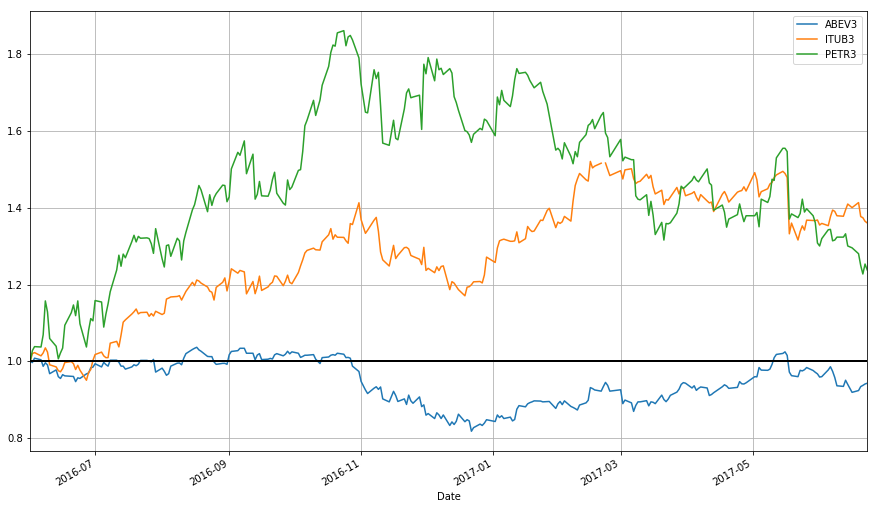

In [57]:
stock_return.plot(grid = True).axhline(y = 1, color = "black", lw = 2)

In [58]:
# Vamos usar a funçao log do NumPy's
import numpy as np
 
stock_change = stocks.apply(lambda x: np.log(x) - np.log(x.shift(1))) # shift moves dates back by 1.
stock_change.head()

,ABEV3,ITUB3,PETR3
Date,,,
2016-06-01,NaN,NaN,NaN
2016-06-02,-0.003107,0.020143,0.027477
2016-06-03,0.011346,0.002490,0.010228
2016-06-06,-0.004111,-0.008323,-0.000925
2016-06-07,-0.017139,0.007494,0.030098


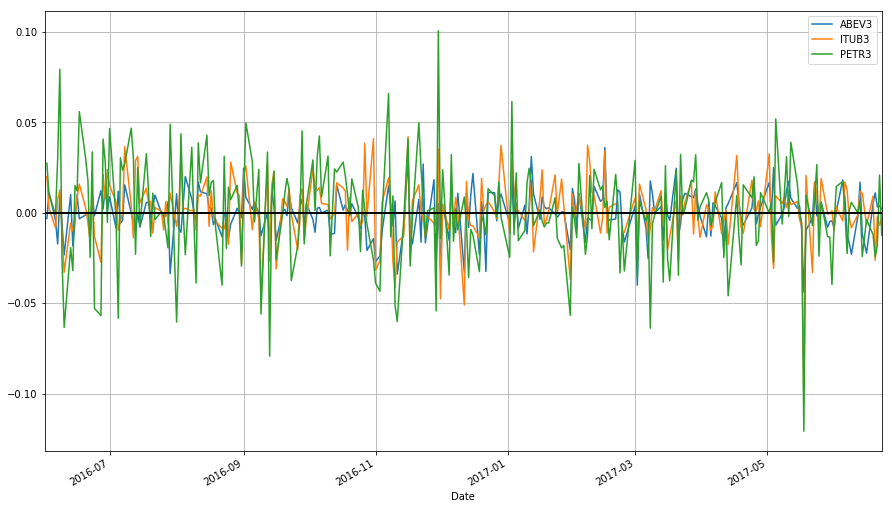

In [59]:
stock_change.plot(grid = True).axhline(y = 0, color = "black", lw = 2)

# Médias Móveis

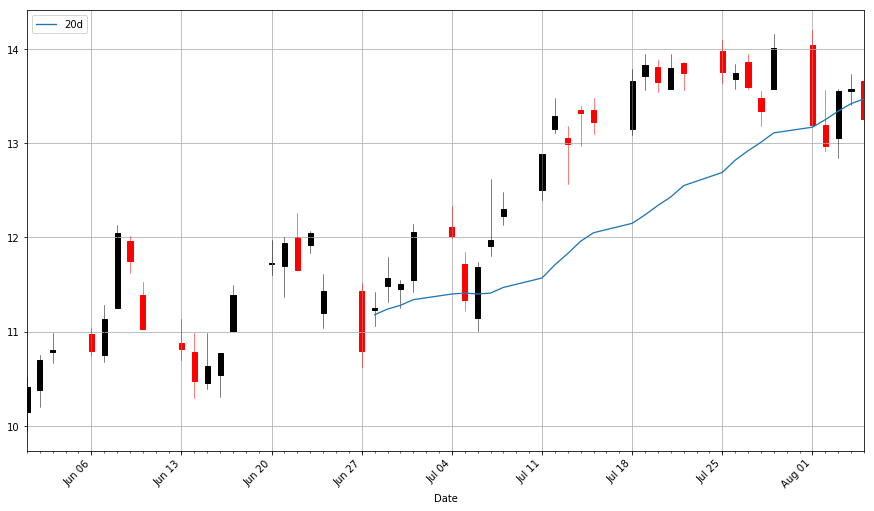

In [60]:
petr3["20d"] = np.round(petr3["Close"].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(petr3.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

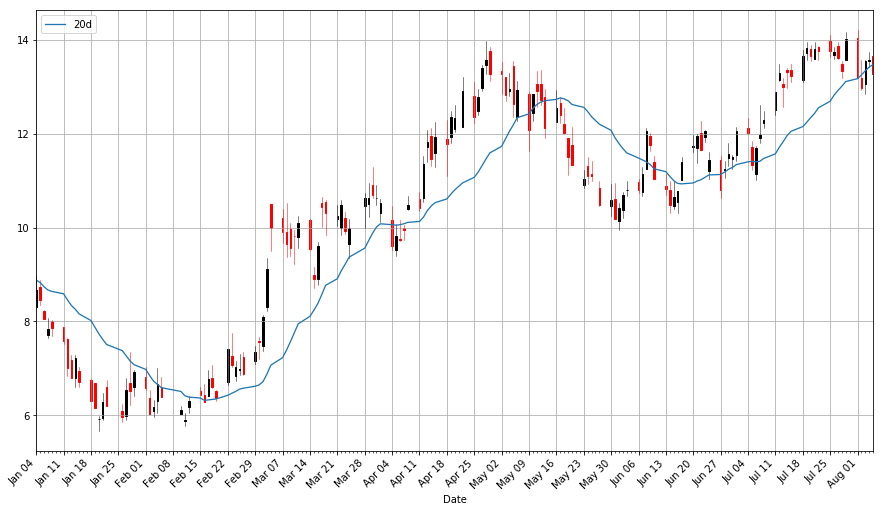

In [61]:
start = datetime.datetime(2010,1,1)
petr3 = wb.DataReader("BVMF:PETR3", "google", start, end)
petr3["20d"] = np.round(petr3["Close"].rolling(window = 20, center = False).mean(), 2)
 
pandas_candlestick_ohlc(petr3.loc['2016-01-04':'2016-08-07',:], otherseries = "20d")

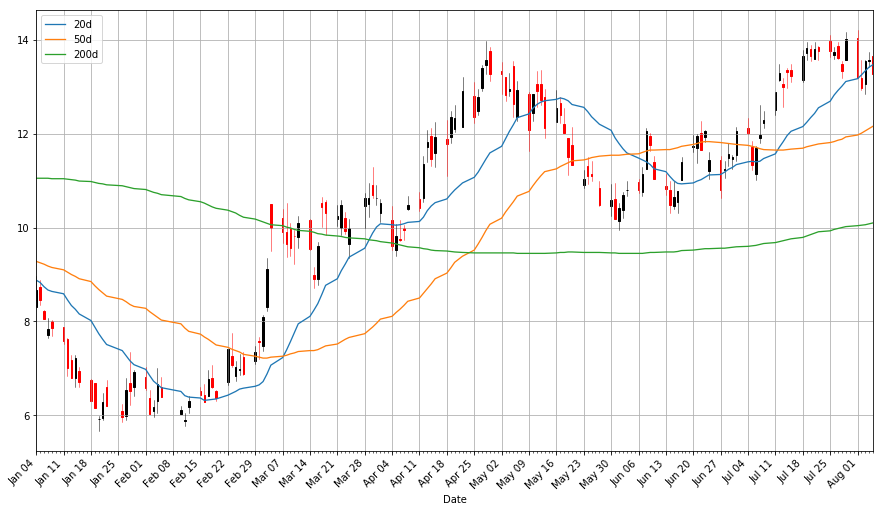

In [62]:
petr3["50d"] = np.round(petr3["Close"].rolling(window = 50, center = False).mean(), 2)
petr3["200d"] = np.round(petr3["Close"].rolling(window = 200, center = False).mean(), 2)
 
pandas_candlestick_ohlc(petr3.loc['2016-01-04':'2016-08-07',:], otherseries = ["20d", "50d", "200d"])